In [ ]:
#Data from https://crcns.org/data-sets/challenges/ch-epfl-2009/about-ch-epfl-2009
#https://brian2.readthedocs.io/en/stable/examples/frompapers.Brette_Gerstner_2005.html

In [1]:
import sbi
import numpy as np
import matplotlib.pyplot as plt

In [3]:
path='C:/Users/koester_lab/Documents/Maria/rihanna/crcns-ch-epfl-2009-challengeA/voltage_allrep.txt'
current_path='C:/Users/koester_lab/Documents/Maria/rihanna/crcns-ch-epfl-2009-challengeA/current.txt'
observations=np.loadtxt(path)

In [6]:
print(observations.shape)

(390000, 13)


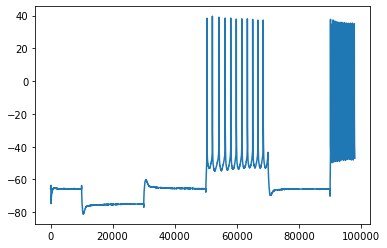

In [16]:
plt.plot(observations[:98000,0])

In [49]:
import numpy as np
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# sbi
import sbi.utils as utils_
from sbi.inference.base import infer

from brian2 import *

def simulator(parameter_set):
    tauw=parameter_set[0].item()*ms
    a=parameter_set[1].item()*nS
    b=parameter_set[2].item()*nA
    Vr = parameter_set[3].item()*mV
    
    # Parameters
    C = 281 * pF
    gL = 30 * nS
    taum = C / gL
    EL = -70.6 * mV
    VT = -50.4 * mV
    DeltaT = 2 * mV
    Vcut = VT + 5 * DeltaT
    
    I=np.loadtxt('C:/Users/koester_lab/Documents/Maria/rihanna/crcns-ch-epfl-2009-challengeA/current.txt')
    dt=1./10000
    
    t = np.arange(0, len(I), 1)*dt
    
    eqs = """
    dvm/dt = (gL*(EL - vm) + gL*DeltaT*exp((vm - VT)/DeltaT) + I - w)/C : volt
    dw/dt = (a*(vm - EL) - w)/tauw : amp
    I : amp
    """

    neuron = NeuronGroup(1, model=eqs, threshold='vm>Vcut',
                         reset="vm=Vr; w+=b", method='euler')
    neuron.vm = EL
    trace = StateMonitor(neuron, 'vm', record=0)
    
    run(39000 * ms)
    
    #print(trace[0].vm[:])
    
    sim_dat=np.array(trace[0].vm[:])
    print(sim_dat)
    return sim_dat

def make_prior():
    #tauw, a, b, Vr = 144*ms, 4*nS, 0.0805*nA, -70.6*mV
    prior_min = [100,1,0.001,-80]
    prior_max = [300,10,0.1,-60]
    prior = utils_.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                        high=torch.as_tensor(prior_max))
    print(np.array(prior.sample((1,)))[0])
    return prior

prior=make_prior()
posterior = infer(simulator, prior, method='SNPE', 
                  num_simulations=10, num_workers=1)
    

[ 2.9153183e+02  9.2940407e+00  1.5856123e-02 -6.9494400e+01]

[-0.0706     -0.0706     -0.0706     ... -0.07059993 -0.07059993
 -0.07059993]


[-0.0706     -0.0706     -0.0706     ... -0.07059994 -0.07059994
 -0.07059994]
[-0.0706     -0.0706     -0.0706     ... -0.07059992 -0.07059992
 -0.07059992]
[-0.0706     -0.0706     -0.0706     ... -0.07059993 -0.07059993
 -0.07059993]
[-0.0706     -0.0706     -0.0706     ... -0.07059993 -0.07059993
 -0.07059993]
[-0.0706     -0.0706     -0.0706     ... -0.07059994 -0.07059994
 -0.07059994]
[-0.0706     -0.0706     -0.0706     ... -0.07059993 -0.07059993
 -0.07059993]
[-0.0706     -0.0706     -0.0706     ... -0.07059994 -0.07059994
 -0.07059994]
[-0.0706     -0.0706     -0.0706     ... -0.07059992 -0.07059992
 -0.07059992]
[-0.0706     -0.0706     -0.0706     ... -0.07059993 -0.07059993
 -0.07059993]
[-0.0706     -0.0706     -0.0706     ... -0.07059993 -0.07059993
 -0.07059993]

Neural network successfully converged after 60 epochs.


In [51]:
samples = posterior.sample((100,), 
                           x=observations[:,0])

In [52]:
samples=samples.numpy()

In [54]:
print(samples.shape)

(100, 4)


[-0.0706     -0.0706     -0.0706     ... -0.07059992 -0.07059992
 -0.07059992]


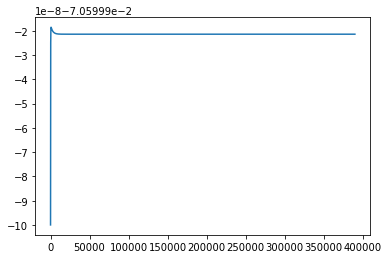

In [55]:
t=simulator(samples[0,:])
plt.plot(t)